## Problem Statement

Customer churn refers to customers leaving a service provider.
In this project, we aim to predict whether a customer will churn (1)
or not churn (0) based on their demographic, service usage, and
contract information.

This is a **binary classification problem** because:
- The target variable has two classes: Churn / Not Churn
- The output is categorical (0 or 1)


## Step 1: Import Required Libraries

Import libraries for:
- Data manipulation and analysis
- Visualization
- Machine learning models and evaluation

In [44]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)

## Step 2: Load Dataset

Load the Telco Customer Churn dataset.
The dataset contains customer-level information along with churn labels.

In [45]:
df = pd.read_csv("/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Step 3: Initial Data Inspection

Inspect the dataset to understand:
- Shape of the data
- Column data types
- Presence of missing values

In [46]:
df.shape

(7043, 21)

In [47]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [48]:
df.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [49]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [50]:
df.duplicated().sum()

0

## Step 4: Dropping Irrelevant Columns & make 'Total Charges' as numeric column

Since there is no missing data, drop irrelevant columns. 
The customerID column is an identifier and does not contribute
to churn prediction.


In [51]:
df.drop(columns=['customerID'], inplace=True)

In [52]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [53]:
df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

/tmp/ipykernel_47/2840544469.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)


## Step 5: Exploratory Data Analysis (EDA)

### Step 5.1: Churn Distribution

Analyze the balance between churned and non-churned customers.

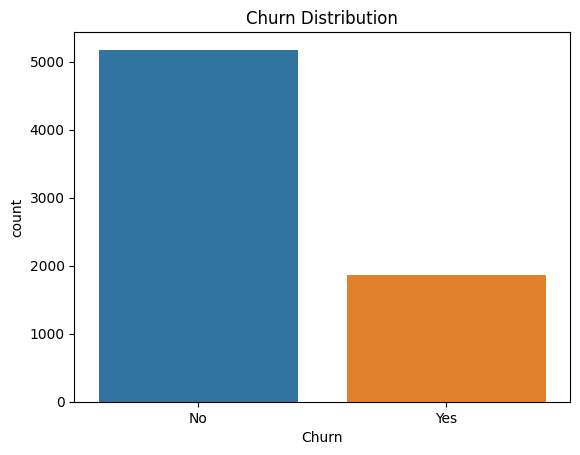

In [54]:
sns.countplot(x='Churn', data=df)
plt.title("Churn Distribution")
plt.show()

Interpretation

- Dataset is imbalanced
- Fewer churned customers → accuracy alone is misleading

### Step 5.2: Churn vs Contract Type

Contract duration is expected to strongly influence churn.

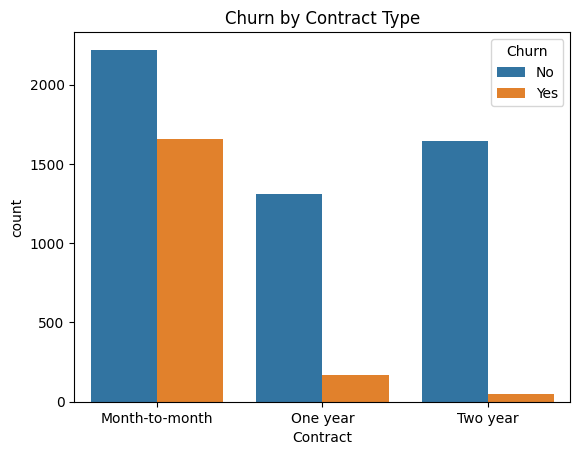

In [55]:
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title("Churn by Contract Type")
plt.show()

### Step 5.3: Churn vs Tenure

Analyze how customer tenure affects churn behavior.

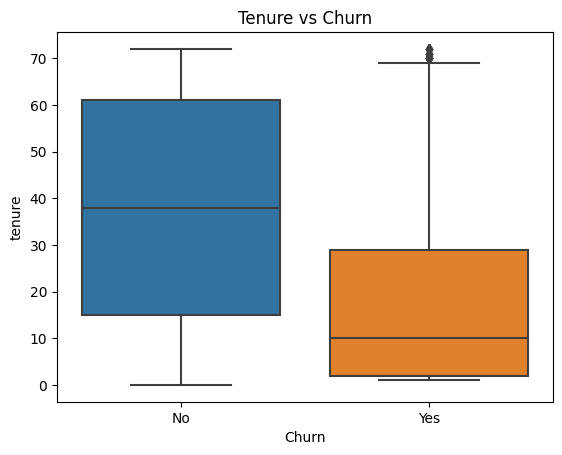

In [56]:
sns.boxplot(x='Churn', y='tenure', data=df)
plt.title("Tenure vs Churn")
plt.show()

### Step 5.4: Monthly Charges Distribution

Check whether customers with higher monthly charges churn more.

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


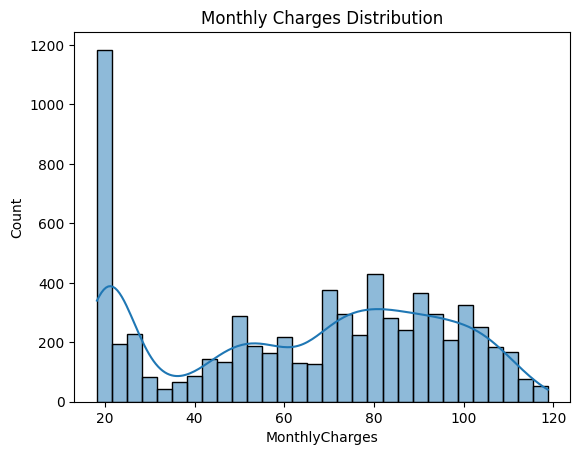

In [57]:
sns.histplot(df['MonthlyCharges'], bins=30, kde=True)
plt.title("Monthly Charges Distribution")
plt.show()

### Step 5.5: Correlation Matrix

Correlation helps identify relationships between numerical features.

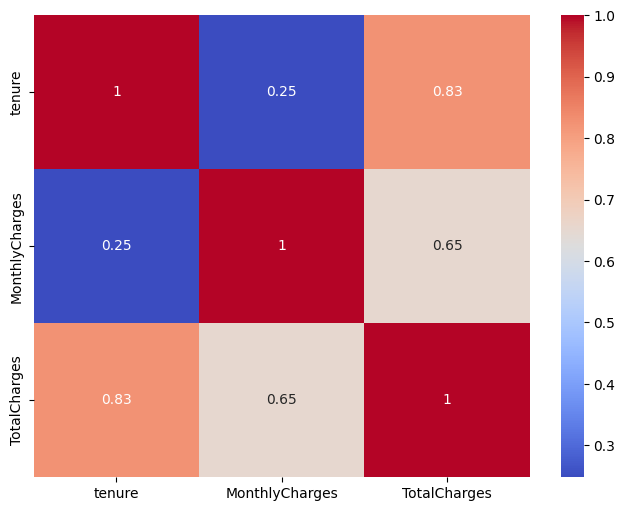

In [58]:
plt.figure(figsize=(8,6))
sns.heatmap(df[['tenure','MonthlyCharges','TotalCharges']].corr(),
            annot=True, cmap='coolwarm')
plt.show()

## Step 6: Encoding Categorical Variables

Machine learning models require numerical input.
Use:
- Label Encoding for binary categorical variables
- One-Hot Encoding for multi-category variables


In [59]:
binary_cols = ['gender', 'Partner', 'Dependents', 'PhoneService',
               'PaperlessBilling', 'Churn']

le = LabelEncoder()
for col in binary_cols:
    df[col] = le.fit_transform(df[col])

In [60]:
df = pd.get_dummies(df, drop_first=True)

## Step 7: Feature Scaling

Scaling is important for:
- Logistic Regression
- Distance-based algorithms

Standardize numerical features.

In [61]:
X = df.drop('Churn', axis=1)
y = df['Churn']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## Step 8: Train-Test Split

Split data into training and test sets to evaluate performance
on unseen data.

In [62]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

## Step 9: Model Training
### Step 9.1: Logistic Regression

Logistic Regression is a baseline classification model
that outputs probabilities.


In [63]:
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)

### Step 9.2: Decision Tree Classifier

Decision Trees capture non-linear relationships
and are easy to interpret.

In [64]:
dt = DecisionTreeClassifier(max_depth=5, random_state=42)
dt.fit(X_train, y_train)

y_pred_dt = dt.predict(X_test)

### Step 9.3: Random Forest Classifier

Random Forest is an ensemble method that reduces overfitting
and improves generalization.

In [65]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

## Step 10: Model Evaluation

Accuracy alone is not sufficient due to class imbalance.
We evaluate models using:
- Accuracy
- Precision
- Recall
- F1 Score
- ROC-AUC

In [66]:
def evaluate_model(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "ROC-AUC": roc_auc_score(y_true, y_prob)
    }

In [67]:
results = pd.DataFrame([
    evaluate_model(y_test, y_pred_lr, log_reg.predict_proba(X_test)[:,1]),
    evaluate_model(y_test, y_pred_dt, dt.predict_proba(X_test)[:,1]),
    evaluate_model(y_test, y_pred_rf, rf.predict_proba(X_test)[:,1])
], index=['Logistic Regression', 'Decision Tree', 'Random Forest'])

results

,Accuracy,Precision,Recall,F1 Score,ROC-AUC
Logistic Regression,0.806955,0.658385,0.566845,0.609195,0.841641
Decision Tree,0.794180,0.629630,0.545455,0.584527,0.828358
Random Forest,0.786373,0.625430,0.486631,0.547368,0.820963


## Step 11: Confusion Matrix

Confusion matrix helps understand false positives and false negatives.


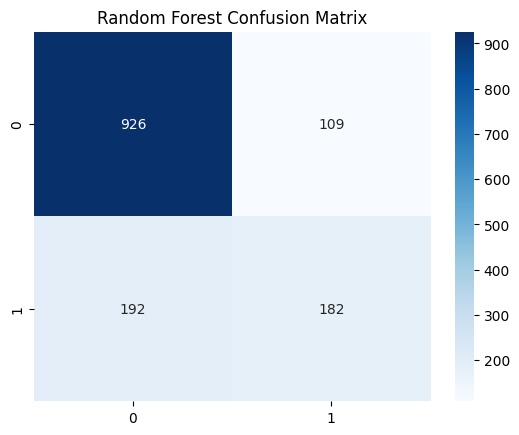

In [68]:
sns.heatmap(confusion_matrix(y_test, y_pred_rf),
            annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()

## Step 12: Cross-Validation

Apply 5-fold cross-validation to ensure model stability.

In [69]:
cv_scores = cross_val_score(
    log_reg, X_scaled, y,
    cv=5, scoring='f1'
)

cv_scores.mean()

0.5983826973185797

## Final Conclusion

- Exploratory analysis revealed that contract type, tenure, and monthly
  charges are strong indicators of customer churn.
- Logistic Regression provided strong baseline performance.
- Random Forest achieved the best overall performance by capturing
  non-linear relationships.
- F1 Score and ROC-AUC were prioritized due to class imbalance.

This project demonstrates a complete classification workflow from
EDA to model evaluation.